# IBM HR Analytics Employee Attrition & Performance
Predict attrition of your valuable employees

https://www.kaggle.com/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset

**Python 3.13**

In [1]:
# data analysis
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder
from category_encoders import MEstimateEncoder, TargetEncoder
from category_encoders.woe import WOEEncoder
from sklearn.model_selection import train_test_split

# Feature Importance
from boruta import BorutaPy

# Over Sampling Technique
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# system operations
import sys

# load ML code
sys.path.insert(0, './')
%load_ext autoreload
%autoreload 2

# pandas display options
pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
# review environment
print(np.__version__)
print(pd.__version__)
print(sys.version)
print(sns.__version__)

2.2.0
2.2.3
3.13.1 | packaged by Anaconda, Inc. | (main, Dec 11 2024, 10:35:08) [Clang 14.0.6 ]
0.13.2


In [3]:
# utilities

def woe_encode_cat_feats_with_contigency_table(data_df, target, multi_cat_feats_list, regularization=1.0, verbose=False):
    '''
    1. Encodes categorical features found in multi_cat_feats_list using Weight of Evidence encoding.
    
    2. For the same features it creates a contigency table having the amount of positive, negative
    and total instances for each feature category A positive instance is one for which the
    dependent/target variable is equal to 1 or "Yes", a negative is one for which the target
    variable is 0 or "No". Also, this table has the empirical probabilities for each category given
    the target is 1 (positive) or 0 (negative). Lastly, the weight of evidence (WOE) and information
    value (IV) are calculated for each category. All calucations are done based on the Pandas DataFrame
    data_df holding the data.

    Returns the contigency table. The original DataFrame is updated in-place with the encoded data.
    '''

    enc = WOEEncoder(verbose=1, cols=multi_cat_feats_list).fit(data_df[multi_cat_feats_list], data_df[target], regularization=regularization)
    encoded = enc.transform(data_df[multi_cat_cols_list])
    data_df[multi_cat_feats_list] = encoded
    
    total_positive = data_df[target].sum()
    total_negative = len(data_df) - total_positive
    cols = ['Feature', 'Category', 'Positive', 'Negative', 'Total', 'Prob(Category|Target=1)', 'Prob(Category|Target=0)', 'WOE', 'IV']
    contigency_tables_df = pd.DataFrame(columns=cols)
    for feat in multi_cat_feats_list:
        feat_ord_scores_pds = [x['mapping'] for x in enc.ordinal_encoder.mapping if x['col'] == feat][0]
        # drop nan key added by the encoder since our data have no nan
        feat_woe_scores_dict = {woe : original_cat for (idx, woe) in enc.mapping[feat].items()
                                for (original_cat, ordinal_idx) in feat_ord_scores_pds.items()
                                if idx == ordinal_idx and isinstance(original_cat, str)}
    
        # contigency table
        contigency_df = data_df.groupby(feat)[target].agg(Positive='sum', Total='count').reset_index()
        contigency_df['Negative'] = contigency_df['Total'] - contigency_df['Positive']
        contigency_df['Feature'] = feat
        contigency_df['Category'] = [feat_woe_scores_dict[x] for x in contigency_df[feat]]
        # calculate proportions
        contigency_df['Prob(Category|Target=1)'] = contigency_df['Positive'] / total_positive
        contigency_df['Prob(Category|Target=0)'] = contigency_df['Negative'] / total_negative
        # the feature values are encoded using their woe scores, so we use them directly
        contigency_df['WOE'] = contigency_df[feat]
        contigency_df['IV'] = (contigency_df['Prob(Category|Target=1)'] - contigency_df['Prob(Category|Target=0)']) * contigency_df[feat]
        # update
        contigency_df = contigency_df[cols]
        if len(contigency_tables_df) == 0:
            contigency_tables_df = contigency_df
        else:
            contigency_tables_df = pd.concat([contigency_tables_df, contigency_df], ignore_index=True)

        if verbose:
            print('->', '{0: <15}'.format(feat), 'Information Value:', '{0:.3f}'.format(contigency_df['IV'].sum())
                  , '\nclasses:', '{0: <20}'.format(str(list(feat_woe_scores_dict.values())))
                  , 'encoded as:', ['{0:.3f}'.format(vl) for vl in feat_woe_scores_dict.keys()])

    return contigency_tables_df


def plot_cat_feats_by_iv_ranking(contigency_tables_df):
    '''
    Plots categorical features found in contigency_tables_df Pandas DataFrame
    ranked by their information value (IV) value in descending order.
    '''
    feat_ivs_df = contigency_tables_df.groupby('Feature')['IV'].agg(IV='sum').sort_values('IV', ascending=False)
    iv_thresholds_list = [0, 0.02, .1, .3, .5]
    clr_palette = sns.color_palette('crest_r', n_colors=len(feat_ivs_df), desat=1)
    plt.figure(figsize=(8, 5))
    ax = sns.barplot(data=feat_ivs_df, y='IV', x='Feature', hue='Feature', palette=clr_palette)
    
    # set x, y axis properties
    ax.set(ylim=(0, .6))
    ax.tick_params(labelsize=11, labelcolor=[0, 0, 0, 0.5])
    ax.get_yaxis().set_visible(False)
    
    # annotate with iv values
    for i, p in enumerate(ax.patches):
        h, w, x, y = p.get_height(), p.get_width(), p.get_x(), p.get_y()
        xy = (x + w/2., y + h/2)
        text = '{0:0.3f}'.format(feat_ivs_df['IV'].iloc[i])
        ax.annotate(text=text, xy=xy, ha='center', va='center', color='white', size=11, weight='bold')
    
    # show IV thresholds
    leg = ax.legend(['< 0.02 useless', '< 0.1 weak', '< 0.3 medium', '<= 0.5 strong', '> 0.5 suspicious']
                    , ncol=1, loc='best', frameon=False, fontsize='medium', labelcolor=[0, 0, 0, 0.5]
                    , title='Predictive Power Scale')
    # lighten legend bullet points
    for lh in leg.legend_handles:
        lh.set_alpha(0.5)
    leg.get_title().set_alpha(0.5)
        
    # ax title
    ax.set_title('Multi-value categorical features ranked by predictive power (IV)')
    # remove clutter
    sns.despine(left=True, bottom=True)


def plot_cat_feat_woe_iv(feat, contigency_tables_df, figsize=(10, 5)):
    '''
    Plots a categorical feature against its weight of evidence (WOE) and
    information value (IV).
    '''

    feat_df = contigency_tables_df[contigency_tables_df['Feature'] == feat].copy()
    feat_df['Not Leave %'] = feat_df['Negative'] / feat_df['Total']

    rows, cols = 1, 2
    fig, axes = plt.subplots(rows, cols, sharey=True, figsize=figsize)
    
    sns.set_color_codes('muted')
    sns.barplot(data=feat_df, x='WOE', y='Category', color='b', ax=axes[0])
    axes[0].set_title('Weight of Evidence (WoE) by ' + feat)
    axes[0].set_ylabel('')
    
    sns.barplot(data=feat_df, x='IV', y='Category', color='b', ax=axes[1])
    axes[1].set_title('Information Value (IV) Contribution by ' + feat)
    
    sns.despine(left=True, bottom=True)


def plot_target_by_cat_feat(target, feat, contigency_tables_df, figsize=(10, 5)):
    '''
    Plots data dependent variable aka target against a categorical feature both
    using absolute and relative values.
    '''

    
    feat_df = contigency_tables_df[contigency_tables_df['Feature'] == feat].copy()
    feat_df['Not Leave %'] = feat_df['Negative'] / feat_df['Total']
    feat_df['Total %'] = 1
    
    rows, cols = 1, 2
    fig, axes = plt.subplots(rows, cols, sharey=True, figsize=figsize)
    sns.set_color_codes('pastel')
    sns.barplot(data=feat_df, y='Category', x='Total', orient='h', color='b', label='Yes', ax=axes[0])
    sns.set_color_codes('muted')
    sns.barplot(data=feat_df, y='Category', x='Negative', orient='h', color='b', label='No', ax=axes[0])
    
    # annotate with values
    for i, p in enumerate(axes[0].patches[: len(feat_df)]):
        h, w, x, y = p.get_height(), p.get_width(), p.get_x(), p.get_y()
        xy = (x + w/3., y + h/2)
        text = '{0:d}'.format(feat_df['Negative'].iloc[i])
        axes[0].annotate(text=text, xy=xy, ha='center', va='center', color='white', size=11, weight='bold')
        xy = (x + .87 * w, y + h/2)
        if feat_df['Not Leave %'].iloc[i] < .9:
            text = '{0:d}'.format((feat_df['Positive'].iloc[i]))
            axes[0].annotate(text=text, xy=xy, ha='center', va='center', color='white', size=11, weight='bold')
        xy = (16 + w, y + h/2)
        text = '{0:d}'.format((feat_df['Total'].iloc[i]))
        axes[0].annotate(text=text, xy=xy, ha='center', va='center', color=[0, 0, 0, 0.3], size=11, weight='bold')
    
    axes[0].set_title(target + ' by ' + feat)
    axes[0].set_xlabel('')
    axes[0].set_xticks([])
    axes[0].set_ylabel('');
    axes[0].legend(title=target, ncol=1, frameon=False, bbox_to_anchor=(1, 1))
    
    sns.set_color_codes('pastel')
    sns.barplot(data=feat_df, y='Category', x='Total %', orient='h', color='b', ax=axes[1])
    sns.set_color_codes('muted')
    sns.barplot(data=feat_df, y='Category', x='Not Leave %', orient='h', color='b', ax=axes[1])
    
    for i, p in enumerate(axes[1].patches[: len(feat_df)]):
        h, w, x, y = p.get_height(), p.get_width(), p.get_x(), p.get_y()
        xy = (x + w/3., y + h/2)
        text = '{0:2.1f}'.format(100 * feat_df['Not Leave %'].iloc[i]) + '%'
        axes[1].annotate(text=text, xy=xy, ha='center', va='center', color='white', size=11, weight='bold')
        xy = (x + .9 * w, y + h/2)
        if feat_df['Not Leave %'].iloc[i] < .9:
            text = '{0:2.1f}'.format(100 * (1 - feat_df['Not Leave %'].iloc[i])) + '%'
            axes[1].annotate(text=text, xy=xy, ha='center', va='center', color='white', size=11, weight='bold')
    
    sns.despine(left=True, bottom=True)
    
    axes[1].set_title(target + ' % by ' + feat)
    axes[1].set_xlabel('')
    axes[1].set_xticks([])
    axes[1].set_ylabel('');


def plot_features_boxplots(data_df, feats_list, exclude_feats_list=[], cols=6, figsize=(20, 25)):
    '''
    Plots boxplots for all features in feats_list which are not in exclude_feats_list.
    '''

    feats_list = [f for f in feats_list if f not in exclude_feats_list]
    print('Create boxplots for', len(feats_list), 'features.')
    rows = len(feats_list) // cols if len(feats_list) % cols == 0 else len(feats_list) // cols + 1
    fig, axes = plt.subplots(rows, cols, figsize=figsize)

    for i, feat in enumerate(feats_list):
        if i % cols != 0:
            continue
        for j in [i + x for x in range(cols)]:
            if j == len(feats_list):
                break
            ax = axes[i // cols, j % cols] if rows > 1 and cols > 1 else axes[j] if rows * cols > 1 else axes
            sns.boxplot(data=data_df, y=feats_list[j], orient='v', fill=False
                        , notch=True, medianprops={"color": "r", "linewidth": 2}
                        , showmeans=True, meanprops={'marker':'o', 'markerfacecolor':'white', 'markeredgecolor':'black', 'markersize':'8'}
                        , ax=ax)
            ax.set_title(feats_list[j])
            ax.set_ylabel('')
            sns.despine(right=True, top=True, bottom=True)


def plot_numerical_correlation_heatmap(data_df, num_feats_list, method='pearson', threshold=-1, figsize=(15,10)):
    data_corr = data_df[num_feats_list].corr(method=method)
    # mask for the upper triangle
    mask = np.zeros_like(data_corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    
    # heatmap with mask
    # generate a custom diverging colormap
    # cmap = sns.diverging_palette(10, 220, as_cmap=True)
    cmap = sns.light_palette((210, 90, 60), input="husl")
    plt.figure(figsize=figsize)
    sns.heatmap(data_corr[data_corr.abs() > threshold], mask=mask, cmap=cmap, annot=True, fmt=".2f");


# 1. Load data

It is assumed the data are tabular i.e. they are split into columns and rows. Each column represents a distinct variable/feature/field and each row contains the corresponding values for every and each column. The values from row to row vary in general; it is possible though for some columns the value to be the same across all rows.

In [31]:
# kaggle
# data_path = "/kaggle/input/ibm-hr-analytics-attrition-dataset/WA_Fn-UseC_-HR-Employee-Attrition.csv"
# local
data_path = '../data/ibm_hr_data.csv'

data_df = pd.read_csv(data_path)

In [32]:
# data sample of first 5 rows
data_df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


# 2. Examine Data
## 2.1 Data discernment

The loaded data can be [categorical](https://en.wikipedia.org/wiki/Categorical_variable), [continuous numerical or discrete numerical](https://www.questionpro.com/blog/numerical-data/). Also, we may have [missing data](https://en.wikipedia.org/wiki/Missing_data) (null values) or data that are constant (have only one value for all entries). Each case requires its own investigation and preparation. Specifically,

- **Categorical data:** They span across a limited set of textual values e.g. "Yes"/"No", "Strongly Disagree"-"Strongly Agree" as in surveys. They are loaded as text e.g. "Yes" or "No" and must be converted to a number so that the machine learning alorithm understands them. This conversion is called [encoding](https://towardsdatascience.com/a-benchmark-and-taxonomy-of-categorical-encoders-9b7a0dc47a8c) and it can be done in many ways such as one-hot encoding, binary encoding, label encoding, ordinal encoding, M-estimates mean encoding, sine and cosine encoders (for data the repeat periodically such as days of the week) and others. Each method has its own pros and cons and what method to use depends on the problem itself.
- **Continuous Numerical Data:** They can take any arbitrary arithmetic value. Given the computer used provides enough precision to store these values, each data column has its own range of values. For instance, a temperature column will have values from -60 to +60 degrees depending on the scale used, Celcious or Farheneit while a cell diameter column may span from 10-30 μm. These diferrences in value range across columns can confuse the ML algorithm and put more emphasis to the greater values. Thus, it is important to use the same range e.g. 0-1 for all columns. Another way to address this, is to ensure all data dome from a normal distribution N(0, 1) of 0 mean and 1 standard deviation. This is called [scaling](https://www.geeksforgeeks.org/ml-feature-scaling-part-2/).
- **Discrete Numerical Data** Similar to numerical data they are numbers but similar to categorical data they may represent categories or counts or distinct levels. We can treat them as categorical data and encode them or leave them as is if we use an algorithm capable of handling them such as [Decision Trees](https://en.wikipedia.org/wiki/Decision_tree) and [Random Forests](https://en.wikipedia.org/wiki/Decision_tree). However, if they are used in a linear model such as regression, we may need to scale them as well. Their statistical processing and intepretation though differ from that of continuous numerical data.
- **Single Value Data**: These data have only one values and therefore they have no predictive power. We can drop these data from any further analysis.
- **Missing Data** For some rows and for some columns data are missing. Here we assume missing data are denoted by `null` or `nan` values. This issue can be resolved in various ways including but not limited to using a single value (mean/median/mode), interpolation, k-NN (nearest neighbors), dropping them completely and consult an expert in the field. Whichever methos is used, it is important to be reported as the final conlusions may differ based on the [missing data imputation approach.](https://pmc.ncbi.nlm.nih.gov/articles/PMC6329020/)
- **Duplicate data** These repeated rows get dropped.

Follows the code detecting the various types of data. Note, for another dataset a more thorough examination may be needed.

In [33]:
# columns having only one unique value and thus they could be dropped
single_value_columns_list = [(col, col_ds.unique()[0]) for col, col_ds in data_df.items() if len(col_ds.unique()) == 1]
# numerical_columns_list = [x for _, x in data_df.items() if x.dtype != 'object']
numerical_columns_list = sorted(list(data_df.describe().columns))
# columns having a limited amount of unique integer values such as in surveys of limited options
# given most surveys have no more than 10 options for a single question, 10 is chosen as a threshold
discrete_columns_list = [col for col, col_ds in data_df.items() if 1 < len(col_ds.unique()) <= 10 and col_ds.dtype.kind in 'ui']
continuous_columns_list = [x for x in numerical_columns_list if x not in discrete_columns_list]

# categorical_columns_list = [x for _, x in data_df.items() if x.dtype == 'object']
categorical_columns_list = sorted(list(set(data_df.columns).difference(numerical_columns_list)))

In [34]:
# data report
print('Data Summary')
print(''.join(['-']*len('Data Summary')))
print('* #Observations (Rows):', data_df.shape[0], '\n* #Features (Columns):', data_df.shape[1], 
      '-> #Categorical:', len(categorical_columns_list),
      '#Numerical:', len(numerical_columns_list), '-> #Continuous:', len(numerical_columns_list) - len(discrete_columns_list),
      '#Discrete:', len(discrete_columns_list),)

print('\n* Null values?', 'Yes' if data_df.isnull().any().any() == np.True_ else 'No')

print('\n* Features having only one value?',
      'Yes ' + str(len(single_value_columns_list)) if len(single_value_columns_list) > 0 else 'False', '\n', single_value_columns_list)

print('\n* Duplicate data?', 'Yes' if data_df.duplicated().sum() > 0 else 'No')

num_positive_cases, num_negative_cases = sum(data_df['Attrition'] == 'Yes'), sum(data_df['Attrition'] == 'No')
print('\n* Imbalanced data?', 'Positive Cases:', num_positive_cases, 'Negative Cases:', num_negative_cases
      , 'Ratio:', '{0: >.3f}'.format(num_positive_cases/num_negative_cases))

print('\nData Details')
print(''.join(['-']*len('Data Details')))
data_df.info()
print('\n* Categorical Features\n', categorical_columns_list,
    '\n\n* Numerical Features',
      '\n** Continuous Features\n', continuous_columns_list,
      '\n\n** Discrete Features\n', discrete_columns_list,)

print('{0: <30}'.format('\n\n*Categorical Column'), '{0: <15}'.format('#Unique Values'), '\tUnique Values')
for dc in categorical_columns_list:
    print('{0: <28}'.format(dc), '{0: >14}'.format(len(data_df[dc].unique())), '\t', data_df[dc].unique())
    
print('{0: <30}'.format('\n\n*Discrete Column'), '{0: <15}'.format('#Unique Values'), '\tUnique Values')
for dc in discrete_columns_list:
    print('{0: <28}'.format(dc), '{0: >14}'.format(len(data_df[dc].unique())), '\t', data_df[dc].unique())

Data Summary
------------
* #Observations (Rows): 1470 
* #Features (Columns): 35 -> #Categorical: 9 #Numerical: 26 -> #Continuous: 15 #Discrete: 11

* Null values? No

* Features having only one value? Yes 3 
 [('EmployeeCount', np.int64(1)), ('Over18', 'Y'), ('StandardHours', np.int64(80))]

* Duplicate data? No

* Imbalanced data? Positive Cases: 237 Negative Cases: 1233 Ratio: 0.192

Data Details
------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null

## 2.2 Data Preprocessing

### Imbalanced data

Almost 20% of the people leave the company and thus the data are imbalanced. Hence, we need to take this fact into account for the subsequent analysis.

### Missing Data

There are no missing data i.e. entries with NaN values (Not a Number).

### Duplicate Data

There are no duplicate data.

### Single Value Features

*'EmploymentCount', 'Over18'* and *'StandardHours'* columns can be dropped as they are of a single value and have no predictive power.

We drop them below as they are unnecessary.

In [35]:
# drop one_value_columns_list while preserving the original data
single_value_feats_list = [f[0] for f in single_value_columns_list]
data_lite_df = data_df.drop(columns=single_value_feats_list, inplace=False)
continuous_columns_list = [x for x in continuous_columns_list if x not in single_value_feats_list]
data_lite_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 32 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeNumber            1470 non-null   int64 
 9   EnvironmentSatisfaction   1470 non-null   int64 
 10  Gender                    1470 non-null   object
 11  HourlyRate                1470 non-null   int64 
 12  JobInvolvement            1470 non-null   int64 
 13  JobLevel                  1470 non-null   int64 
 14  JobRole                 

### Numerical Features

#### Discrete Features

There are 11 of those which are *'Education', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'NumCompaniesWorked', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TrainingTimesLastYear',* and  *'WorkLifeBalance'*. Reviewing their names and unique values we can conclude they are indeed discrete. As they are already numerical, we will not apply any encoding.

#### Continuous Features

The remaining features i.e. *'Age', 'DailyRate', 'DistanceFromHome', 'EmployeeCount', 'EmployeeNumber', 'HourlyRate', 'MonthlyIncome', 'MonthlyRate', 'PercentSalaryHike', 'StandardHours', 'TotalWorkingYears', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion'* and *'YearsWithCurrManager'* are continuous meaning they can take any numerical value.

#### Feature Scaling

For all numerical features, continuous and discrete, we will apply scaling. As each feature has its own range and distribution, it can dominate over other features. To give a rough example, when calculating the mean value of some data, the mean will be towards the data with the highest values. In other words, the data with bigger values dominate those with smaller ones. For the mean example assume we have a dataset A with values `1, 2, 3, 1, 1` and a dataset B with values `1, 2, 3, 1, 50`. Dataset A has a mean `(1 + 2 +3 + 1 + 1)/5 = 1.6` and dataset B has mean `11.4`. Dataset B has a much larger mean compared to dataset A, 7 times larger approximately. The reason for that is that one single value of `50` in dataset B. In a similar way, features with greater values than others, will dominate the learning of almost all major machine learning algorithms and deep learning neural networks. Thus, we have to scale the features so that contribute equally to the learning.

This equality among features applies also to penalizing. When a regularized algorithm is used like Ridge or Lasso, the penalty is applied equally to the features. Put differently, all features are regularized equally. Apart from that, some machine and deep learning algoritms assume the data coming from a normal distribution or like it. Moreover, scaled features enable algorithms using gradient descent to converge faster and more robustly.

To conclude, scaling our features is required for proper modeling.

[Standard scaling](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) is one of the most common scalings. For each data of a feature, it subtracts the feature's mean and divides the result by the feature's standard deviation. In the end, the transformed data have 0 mean and 1 standard deviation. The mean and the standard deviation are calculdated using the feature's data values. However, standard scaling is [sensitive to outliers](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#plot-all-scaling-standard-scaler-section). This is expected as the standard scaler depends on the mean and the standard deviation that both are affected by the sample values.

Therefore, below we see for each feature their boxplot in order to check visually for outliers. If no outliers are found we can apply standard scaling otherwise we can apply another scaler robust to outliers such as one based on [percentiles](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#robustscaler).

There are several [criteria](https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-a-pandas-dataframe) to classify data as [outliers](https://www.statology.org/top-5-statistical-techniques-detect-handle-outliers-data/) such as the z-score, thresholding, quantile filtering and interquartile range (IQR). Here we characterize data as outliers based on the IQR which is simple and robust to data extreme values.

Here is a quick reminder of boxplots.
[Images 1 and 3 from Davids Statistics](https://sites.google.com/site/davidsstatistics/davids-statistics/notched-box-plots), 
[image 2 from DuckDuckGo](https://duckduckgo.com/?q=boxplot+with+mean+marker&t=ffab&atb=v343-1&iar=images&iax=images&ia=images&iai=https%3A%2F%2Fwww.researchgate.net%2Fprofile%2FNabin_Basnet3%2Fpublication%2F321962400%2Ffigure%2Ffig4%2FAS%3A573832927944704%401513823839218%2FDiagram-of-boxplot-components-including-mean-median-1st-and-3rd-quartiles-outliers-and.png),
[image 4 from DuckDuckGo](https://duckduckgo.com/?q=skewd+boxplot&t=ffab&atb=v343-1&iax=images&ia=images&iai=https%3A%2F%2Fwww.simplypsychology.org%2Fwp-content%2Fuploads%2Fbox-plots-distribution.jpg)

<p style="float: left" align="center">
<!-- notched_boxplot_explained.jpg -->
<!-- https://sites.google.com/site/davidsstatistics/davids-statistics/notched-box-plots -->
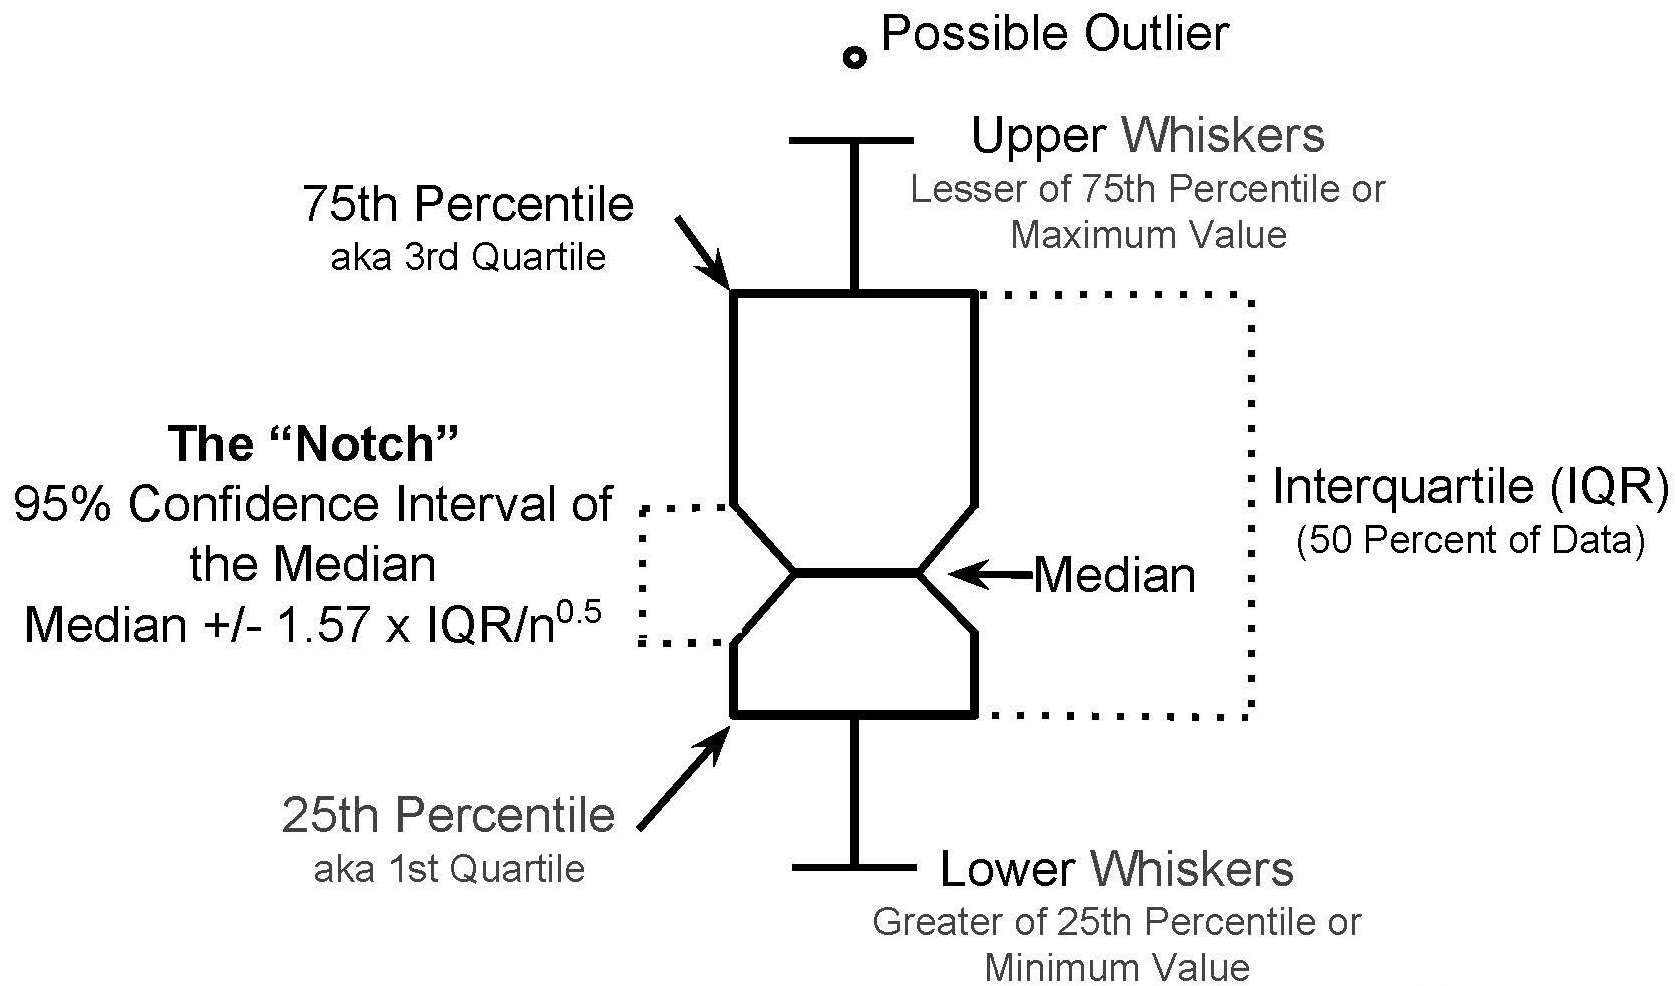

<!-- notched_boxplot_explained_mean.jpg -->
<!-- https://duckduckgo.com/?q=boxplot+with+mean+marker&t=ffab&atb=v343-1&iar=images&iax=images&ia=images&iai=https%3A%2F%2Fwww.researchgate.net%2Fprofile%2FNabin_Basnet3%2Fpublication%2F321962400%2Ffigure%2Ffig4%2FAS%3A573832927944704%401513823839218%2FDiagram-of-boxplot-components-including-mean-median-1st-and-3rd-quartiles-outliers-and.png -->
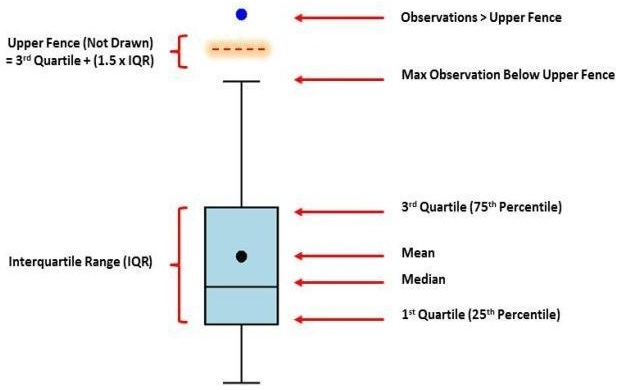

<!-- notched_boxplot_explained_interpretation.jpg -->
<!-- https://sites.google.com/site/davidsstatistics/davids-statistics/notched-box-plots -->
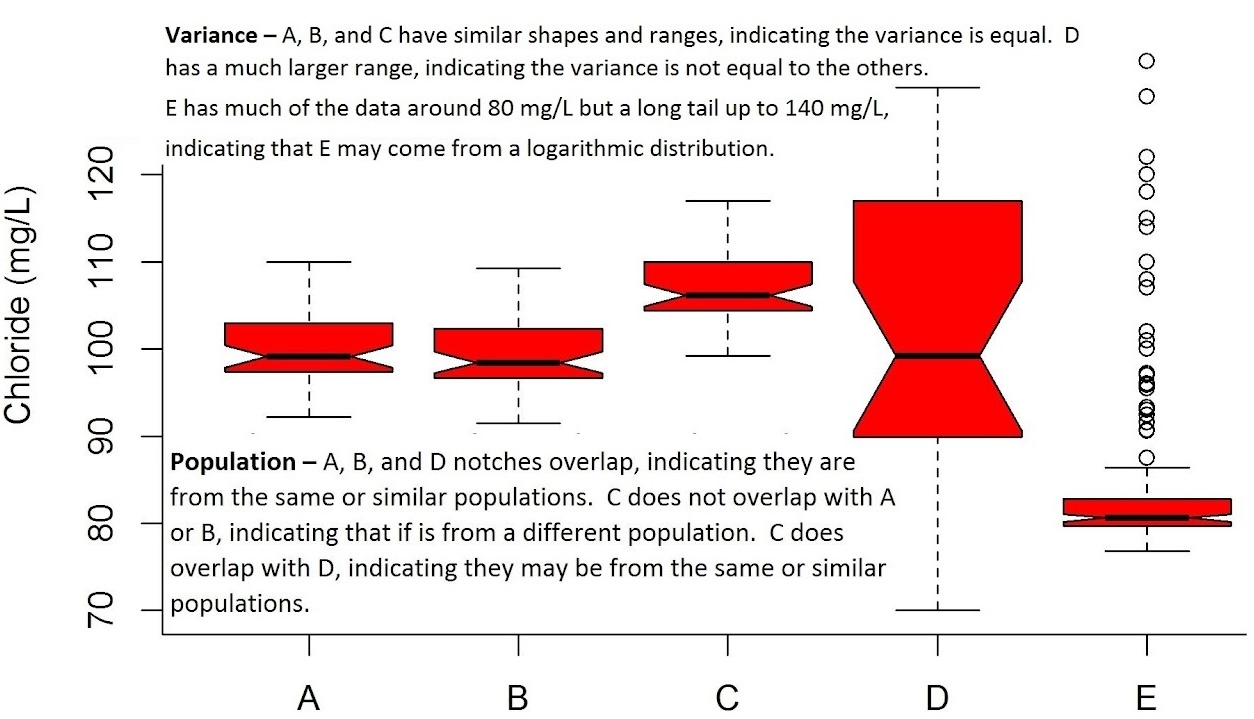
<!-- notched_boxplot_explained_horizontal.jpg -->
<!-- https://www.geeksforgeeks.org/understanding-different-box-plot-with-visualization/ -->
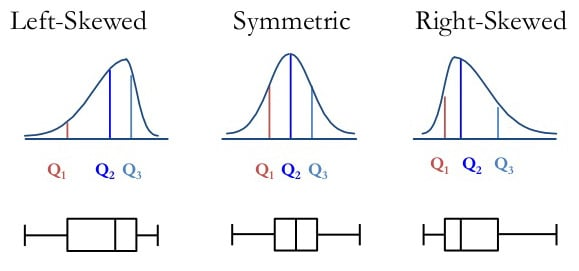
</p>

Create boxplots for 24 features.


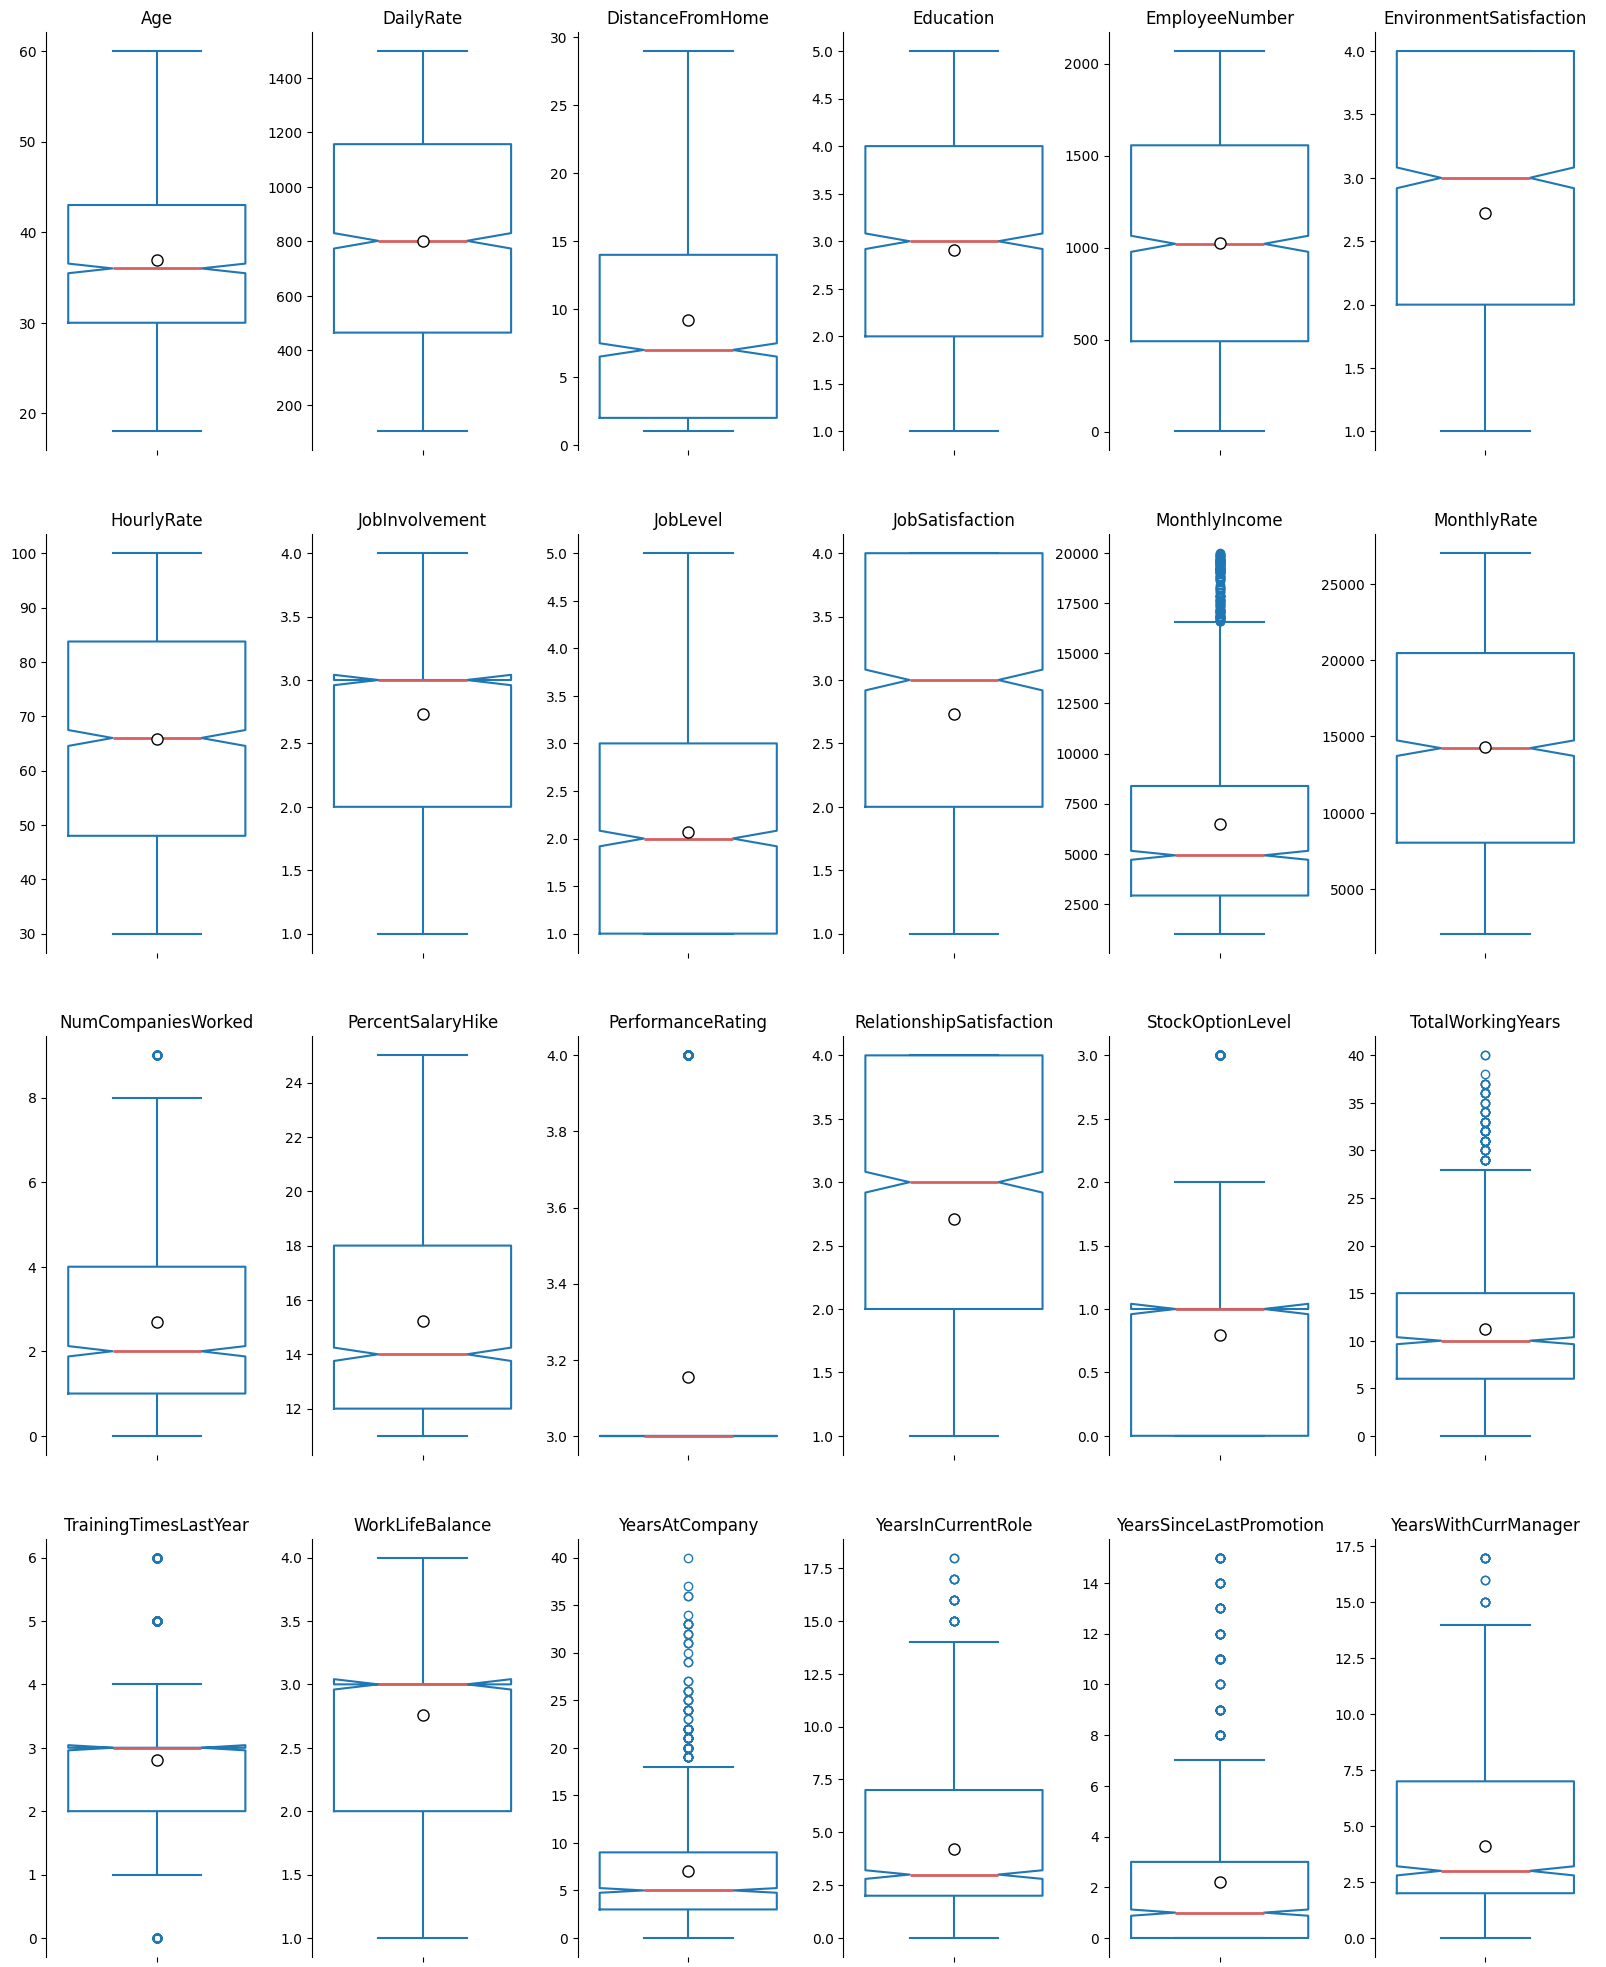

In [36]:
plot_features_boxplots(data_lite_df, numerical_columns_list, single_value_feats_list)

The boxplots above indicate that the features are a blend of features with and without outliers. With the code below we can detect exactly which features are which.

In [37]:
num_feats_list = [x for x in numerical_columns_list if x not in single_value_feats_list]
num_feats_df = data_lite_df[num_feats_list].copy()
iqr_df = num_feats_df.quantile(.75) - num_feats_df.quantile(.25)
lower_whisker_df = num_feats_df.quantile(.25) - 1.5 * iqr_df
upper_whisker_df = num_feats_df.quantile(.75) + 1.5 * iqr_df
outliers_feats_list = num_feats_df.loc[:, ((num_feats_df < lower_whisker_df) | (num_feats_df > upper_whisker_df)).any()].columns.to_list()
non_outliers_feats_list = [x for x in num_feats_list if x not in outliers_feats_list]
print('Features with outliers\n', outliers_feats_list)
print('\nFeatures without outliers\n', non_outliers_feats_list)

Features with outliers
 ['MonthlyIncome', 'NumCompaniesWorked', 'PerformanceRating', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']

Features without outliers
 ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EmployeeNumber', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyRate', 'PercentSalaryHike', 'RelationshipSatisfaction', 'WorkLifeBalance']


For each category of features we can apply an appropriate scaling. Here though, for all features we wil apply a standard scaler as described above making all features to have zero mean and unit standard deviation. This will serve as our base model. The alternatives are either to follow a mixed strategy where we apply a separate scaler for each feature category or to apply a robust scaler to all features.

**Note:** We are not dropping any outliers as part of our base model.

In [14]:
scaler = StandardScaler()
scaler.fit(num_feats_df)
data_lite_df[num_feats_list] = scaler.transform(num_feats_df)
data_lite_df[num_feats_list].head()

,Age,DailyRate,DistanceFromHome,Education,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,0.446,0.743,-1.011,-0.892,-1.701,-0.661,1.383,0.380,-0.058,1.153,-0.108,0.726,2.125,-1.151,-0.426,-1.584,-0.932,-0.422,-2.172,-2.494,-0.165,-0.063,-0.679,0.246
1,1.322,-1.298,-0.147,-1.868,-1.700,0.255,-0.241,-1.026,-0.058,-0.661,-0.292,1.489,-0.678,2.129,2.346,1.191,0.242,-0.165,0.156,0.338,0.489,0.765,-0.369,0.807
2,0.008,1.414,-0.888,-0.892,-1.696,1.170,1.285,-1.026,-0.961,0.246,-0.938,-1.675,1.324,-0.057,-0.426,-0.659,-0.932,-0.550,0.156,0.338,-1.144,-1.168,-0.679,-1.156
3,-0.430,1.461,-0.764,1.062,-1.695,1.170,-0.487,0.380,-0.961,0.246,-0.764,1.243,-0.678,-1.151,-0.426,0.266,-0.932,-0.422,0.156,0.338,0.162,0.765,0.252,-1.156
4,-1.087,-0.524,-0.888,-1.868,-1.691,-1.576,-1.274,0.380,-0.961,-0.661,-0.645,0.326,2.526,-0.877,-0.426,1.191,0.242,-0.679,0.156,0.338,-0.818,-0.615,-0.058,-0.595


For a sample of features, we can see below how they have been centered around zero.

Create boxplots for 5 features.


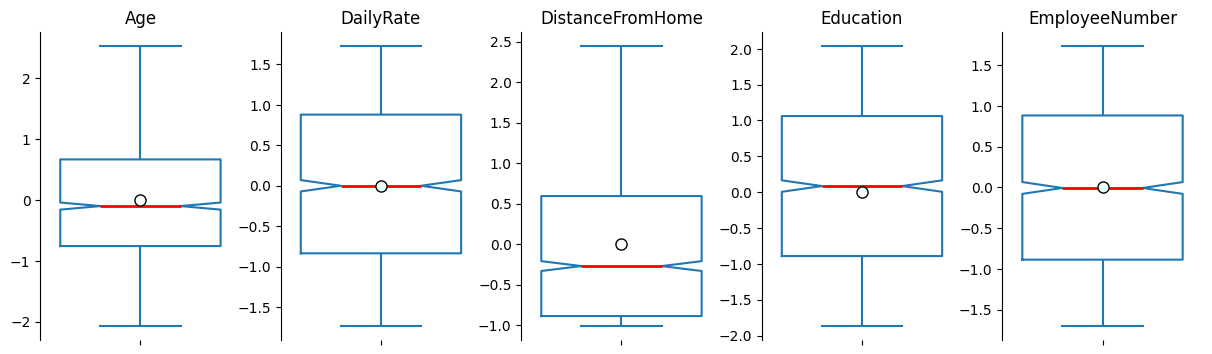

In [15]:
plot_features_boxplots(data_lite_df, ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EmployeeNumber'], cols=5, figsize=(15, 4))

### Categorical Features

There exist 9 of those with textual values and thus we need to convert them into numbers.

#### Two Value Features

These features come with only two options e.g. "Yes" or "No", "Male" or "Female". We can employ binary encoding i.e., convert "Yes" to 1 and "No" to 0. Similarly, "Male" is mapped to 1 and "Female" to 0.

#### Multi Value Features

These attributes are *'BusinessTravel', 'Department', 'EducationField', 'JobRole'* and *'MaritalStatus'*. We cannot really say how they affect someone to stay or leave the company. There exist arguments for and against for each option. At the same time, the hypothesis is that these features somehow *indeed* affect a person to stay or leave (attrition). Therefore, we will use target-based encoding such as M-estimate and [weight of evidence (WOE)](https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html) encoding.

##### Weight of Evidence (WOE)

WOE is a natural choice for this problem because it is a binary classification one. Essentially, WOE is the log-odds within each category i.e., the logarithmic ratio of positive cases over the negative ones. It is also robust to imbalanced data through regularization. It allows to calculate the [information value (IV)](https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html) for each categorical feature. Roughly, IV is a weighted sum of the WOE scores of the categories within a categorical feature enabling to evaluate the predictive power of the feature itself. Put differently, through WOE and IV we can perform a cost-effective preliminary feature selection. Based on the WOE and IV scores for each category of a categorical feature it is possible to tell which category is important to predict the target. This can further simplify and enchance a feature by either combining or dropping categories.

In [16]:
# encode categorical variables
binary_cat_cols_gen = (col for col in categorical_columns_list if len(data_df[col].unique()) == 2)
multi_cat_cols_list = [col for col in categorical_columns_list if len(data_df[col].unique()) > 2]
# binary ones
print('* Binary features')
for feat in binary_cat_cols_gen:
    enc = LabelEncoder()
    enc.fit(data_df[feat])
    print('->', '{0: <15}'.format(feat), 'classes:', '{0: <20}'.format(str(enc.classes_)), 'encoded as:', enc.transform(enc.classes_))
    data_lite_df[feat] = enc.transform(data_df[feat])

# multi value ones
print('\n* Multi valued features')
target = 'Attrition'
contigency_tables_df = woe_encode_cat_feats_with_contigency_table(data_lite_df, target, multi_cat_cols_list, verbose=True)

print('\n\nSample encoded data')
data_lite_df.head()

* Binary features
-> Attrition       classes: ['No' 'Yes']         encoded as: [0 1]
-> Gender          classes: ['Female' 'Male']    encoded as: [0 1]
-> OverTime        classes: ['No' 'Yes']         encoded as: [0 1]

* Multi valued features
-> BusinessTravel  Information Value: 0.117 
classes: ['Travel_Rarely', 'Travel_Frequently', 'Non-Travel'] encoded as: ['-0.090', '0.549', '-0.727']
-> Department      Information Value: 0.053 
classes: ['Sales', 'Research & Development', 'Human Resources'] encoded as: ['0.303', '-0.180', '0.256']
-> EducationField  Information Value: 0.074 
classes: ['Life Sciences', 'Other', 'Medical', 'Marketing', 'Technical Degree', 'Human Resources'] encoded as: ['-0.108', '-0.149', '-0.195', '0.398', '0.524', '0.677']
-> JobRole         Information Value: 0.451 
classes: ['Sales Executive', 'Research Scientist', 'Laboratory Technician', 'Manufacturing Director', 'Healthcare Representative', 'Manager', 'Sales Representative', 'Research Director', 'Human Reso

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,0.446,1,-0.090,0.743,0.303,-1.011,-0.892,-0.108,-1.701,-0.661,0,1.383,0.380,-0.058,0.104,1.153,0.577,-0.108,0.726,2.125,1,-1.151,-0.426,-1.584,-0.932,-0.422,-2.172,-2.494,-0.165,-0.063,-0.679,0.246
1,1.322,0,0.549,-1.298,-0.180,-0.147,-1.868,-0.108,-1.700,0.255,1,-0.241,-1.026,-0.058,0.008,-0.661,-0.295,-0.292,1.489,-0.678,0,2.129,2.346,1.191,0.242,-0.165,0.156,0.338,0.489,0.765,-0.369,0.807
2,0.008,1,-0.090,1.414,-0.180,-0.888,-0.892,-0.149,-1.696,1.170,1,1.285,-1.026,-0.961,0.497,0.246,0.577,-0.938,-1.675,1.324,1,-0.057,-0.426,-0.659,-0.932,-0.550,0.156,0.338,-1.144,-1.168,-0.679,-1.156
3,-0.430,0,0.549,1.461,-0.180,-0.764,1.062,-0.108,-1.695,1.170,0,-0.487,0.380,-0.961,0.008,0.246,-0.295,-0.764,1.243,-0.678,1,-1.151,-0.426,0.266,-0.932,-0.422,0.156,0.338,0.162,0.765,0.252,-1.156
4,-1.087,0,-0.090,-0.524,-0.180,-0.888,-1.868,-0.195,-1.691,-1.576,1,-1.274,0.380,-0.961,0.497,-0.661,-0.295,-0.645,0.326,2.526,0,-0.877,-0.426,1.191,0.242,-0.679,0.156,0.338,-0.818,-0.615,-0.058,-0.595


In [17]:
data_lite_df.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Columns: 32 entries, Age to YearsWithCurrManager
dtypes: float64(29), int64(3)
memory usage: 367.6 KB


All textual data have been encoded as we see above; all data types are either floats or integers.

Moreover, according to [this table](https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html) 
about IV values significance, *'Department'* and *'EducationField'* are weak predictors,  *'BusinessTravel'* has weak to moderate predictive power. *'MaritalStatus'* has medium predictive power and lastly *'JobRole'* has the most power and it is a strong predictor. Notice all 5 features have a mixed effect to attrition. For instance, for singles the WOE score is positive but for married and divorced the scores are negative. In other words, singles are more prone to leave while married and divorced are more keen to stay.

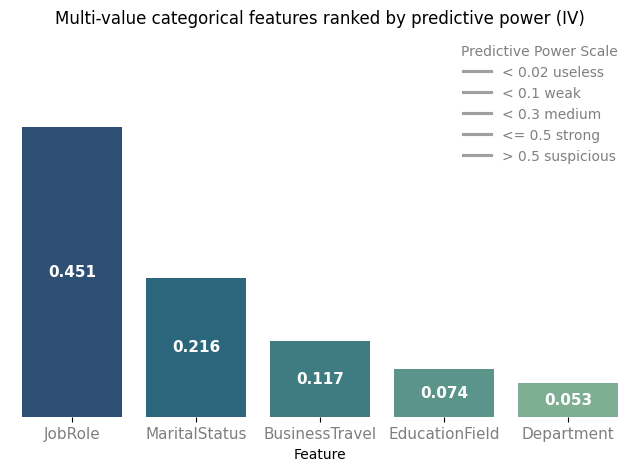

In [18]:
plot_cat_feats_by_iv_ranking(contigency_tables_df)

*'JobRole'* is the most strong predictor for attrition. *'MaritalStatus'* comes second as a moderate predictor. The other features based on IV are not important and thus we could drop them. For this analysis, instead of dropping them, we will create two family of models, one including them and one excluding and we will see what happens.

Below are some more plots exploring the predictive power of *'JobRole'* and *'MaritalStatus'*.

In [19]:
feat = 'JobRole'
feat_df = contigency_tables_df[contigency_tables_df['Feature'] == feat].copy()
feat_df['Not Leave %'] = feat_df['Negative'] / feat_df['Total']
feat_df

,Feature,Category,Positive,Negative,Total,Prob(Category|Target=1),Prob(Category|Target=0),WOE,IV,Not Leave %
12,JobRole,Research Director,2,78,80,0.008,0.063,-1.628,0.089,0.975
13,JobRole,Manager,5,97,102,0.021,0.079,-1.151,0.066,0.951
14,JobRole,Manufacturing Director,10,135,145,0.042,0.109,-0.872,0.059,0.931
15,JobRole,Healthcare Representative,9,122,131,0.038,0.099,-0.867,0.053,0.931
16,JobRole,Research Scientist,47,245,292,0.198,0.199,0.008,-0.000,0.839
17,JobRole,Sales Executive,57,269,326,0.241,0.218,0.104,0.002,0.825
18,JobRole,Human Resources,12,40,52,0.051,0.032,0.494,0.009,0.769
19,JobRole,Laboratory Technician,62,197,259,0.262,0.160,0.497,0.051,0.761
20,JobRole,Sales Representative,33,50,83,0.139,0.041,1.237,0.122,0.602


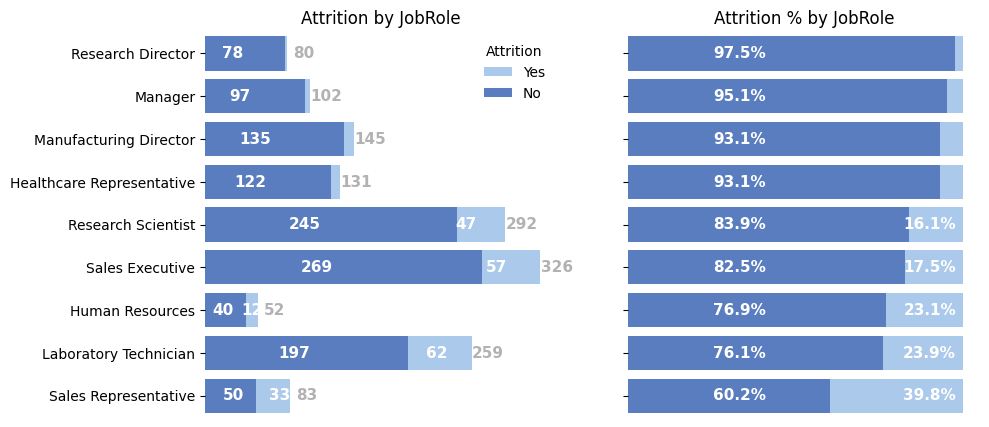

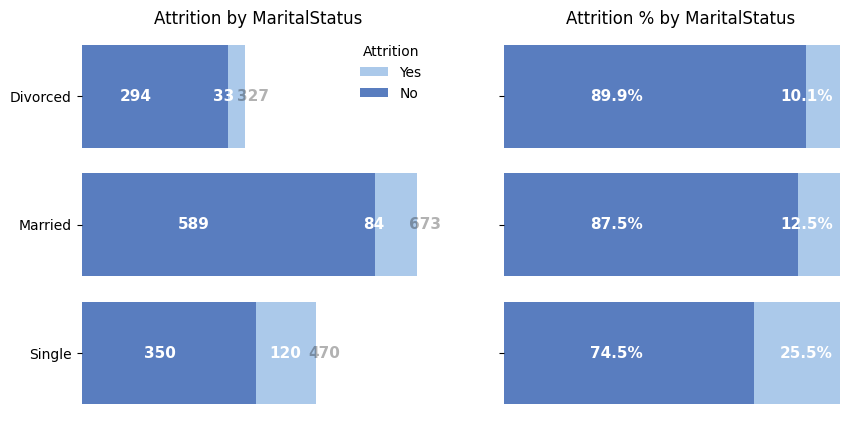

In [20]:
target = 'Attrition'
for feat in ['JobRole', 'MaritalStatus']:
    plot_target_by_cat_feat(target, feat, contigency_tables_df)

For **'JobRole'** we observe there are 3 main groups. The first group includes *'Research Director', 'Manager', 'Manufacturing Director'* and *'Healthcare Representative'*. In this group the attrition is very low i.e., the employees of these job roles don't leave the company. The second group is made of *'Research Scientist'* and *'Sales Executive'*. In this group, the relative attrition is about 16% - 17%. The last and third group is comprised by *'Human Resources', 'Laboratory Technician'* and *'Sales Representative'*. This group has high relative attrition from almost 25% up to almost 40%. This group has more variability compared to the other two.

For **'MaritalStatus'** we notice two groups, one including the married and divorced and another one is the singles themselves. The former group encompasses employees staying at the company whereas the latter group is more volatile. Intuitively, this is expected as married and divorced people may be more settled and in favor of a more stable life while singles are more open to risk.

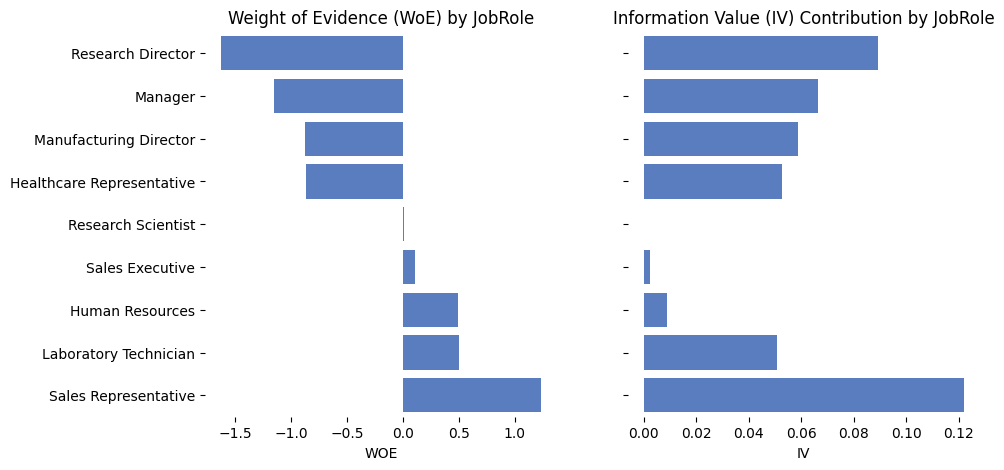

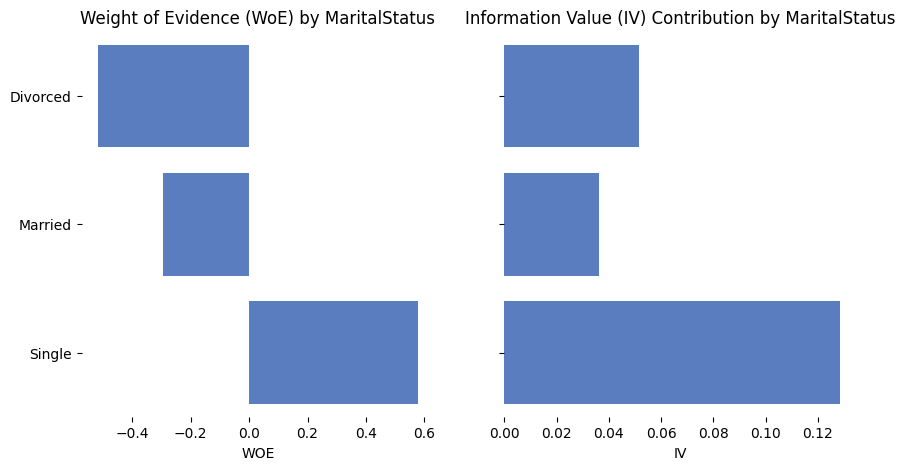

In [21]:
for feat in ['JobRole', 'MaritalStatus']:
    plot_cat_feat_woe_iv(feat, contigency_tables_df)

The graphs above confirm the grouping suggested earlier for both *'JobRole'* and *'MaritalStatus'*.

Specifically, for *'JobRole'* the first group is a strong indicator for someone staying in the company (negative WOE scores) while the third group is a strong indicator for an employee leaving the company (positive WOE scores). The second group appears neutral, neither negative nor positive, and thus we could eliminate it completely or combine it with the other two groups. For instance, *'Research Scientist'*s could be combined with *'Healthcare Representative'*s and *'Sales Executive'* could be united with *'Human Resources'*. For now, we will leave them as is. In terms of informatiion value, *'Human Resources'* could be merged with *'Laboratory Technician'*s.

For *'MaritalStatus'* we notice the singles to be strongly associated with attrition and the rest to be strongly associated with remaining at the company. Interestingly, the divorced ones appear more willing to stay than the married ones.

## 2.2 Feature Relationships

Here, we will examine data correlations and multicolinearity among features.

Given that the dataset is a blend of categorical, discrete and continuous features, we will examine their relationships into groups.

### Numerical Features

[Pearson](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient), [Spearman](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) and [Kendall’s Tau ](https://en.wikipedia.org/wiki/Kendall_rank_correlation_coefficient) correlation coefficients are three common options here. All methods calculate a correlation coefficient ranging in the interval $[−1, 1]$ where
- 1 &rarr; perfect positive correlation
- 0 &rarr; no correlation
- −1 &rarr; perfect negative correlation

These methods however are not equivalent. They measure quite different things:
- Pearson (r): measures the **linear** relationship between two continuous variables.
- Spearman (ρ or rs) and Kendall’s Tau: measure the **monotonic** relationship (not necessarily linear) between two variables.

Also they have their own assumptions. In the context of descriptive analysis, the main difference is that Pearson's assumes linear relationships among variables while Spearman and Kendall assume the relationship to be monotonic, either increasing or decreasing.

Lastly, Pearson's coefficient is sensitive to outliers since through the sample mean, standard deviation and covariance depends on the raw sample values. Spearman's coefficient is more robust as it depends on ranks and not the values directly. Kendall’s Tau is the most robust in outliers as it quantifies the amount of pairwise that increase or decrease.

In [38]:
threshold = .7
data_lite_df[continuous_columns_list].corr(method='pearson')

,Age,DailyRate,DistanceFromHome,EmployeeNumber,HourlyRate,MonthlyIncome,MonthlyRate,PercentSalaryHike,TotalWorkingYears,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
Age,1.000,0.011,-0.002,-0.010,0.024,0.498,0.028,0.004,0.680,0.311,0.213,0.217,0.202
DailyRate,0.011,1.000,-0.005,-0.051,0.023,0.008,-0.032,0.023,0.015,-0.034,0.010,-0.033,-0.026
DistanceFromHome,-0.002,-0.005,1.000,0.033,0.031,-0.017,0.027,0.040,0.005,0.010,0.019,0.010,0.014
EmployeeNumber,-0.010,-0.051,0.033,1.000,0.035,-0.015,0.013,-0.013,-0.014,-0.011,-0.008,-0.009,-0.009
HourlyRate,0.024,0.023,0.031,0.035,1.000,-0.016,-0.015,-0.009,-0.002,-0.020,-0.024,-0.027,-0.020
MonthlyIncome,0.498,0.008,-0.017,-0.015,-0.016,1.000,0.035,-0.027,0.773,0.514,0.364,0.345,0.344
MonthlyRate,0.028,-0.032,0.027,0.013,-0.015,0.035,1.000,-0.006,0.026,-0.024,-0.013,0.002,-0.037
PercentSalaryHike,0.004,0.023,0.040,-0.013,-0.009,-0.027,-0.006,1.000,-0.021,-0.036,-0.002,-0.022,-0.012
TotalWorkingYears,0.680,0.015,0.005,-0.014,-0.002,0.773,0.026,-0.021,1.000,0.628,0.460,0.405,0.459
YearsAtCompany,0.311,-0.034,0.010,-0.011,-0.020,0.514,-0.024,-0.036,0.628,1.000,0.759,0.618,0.769


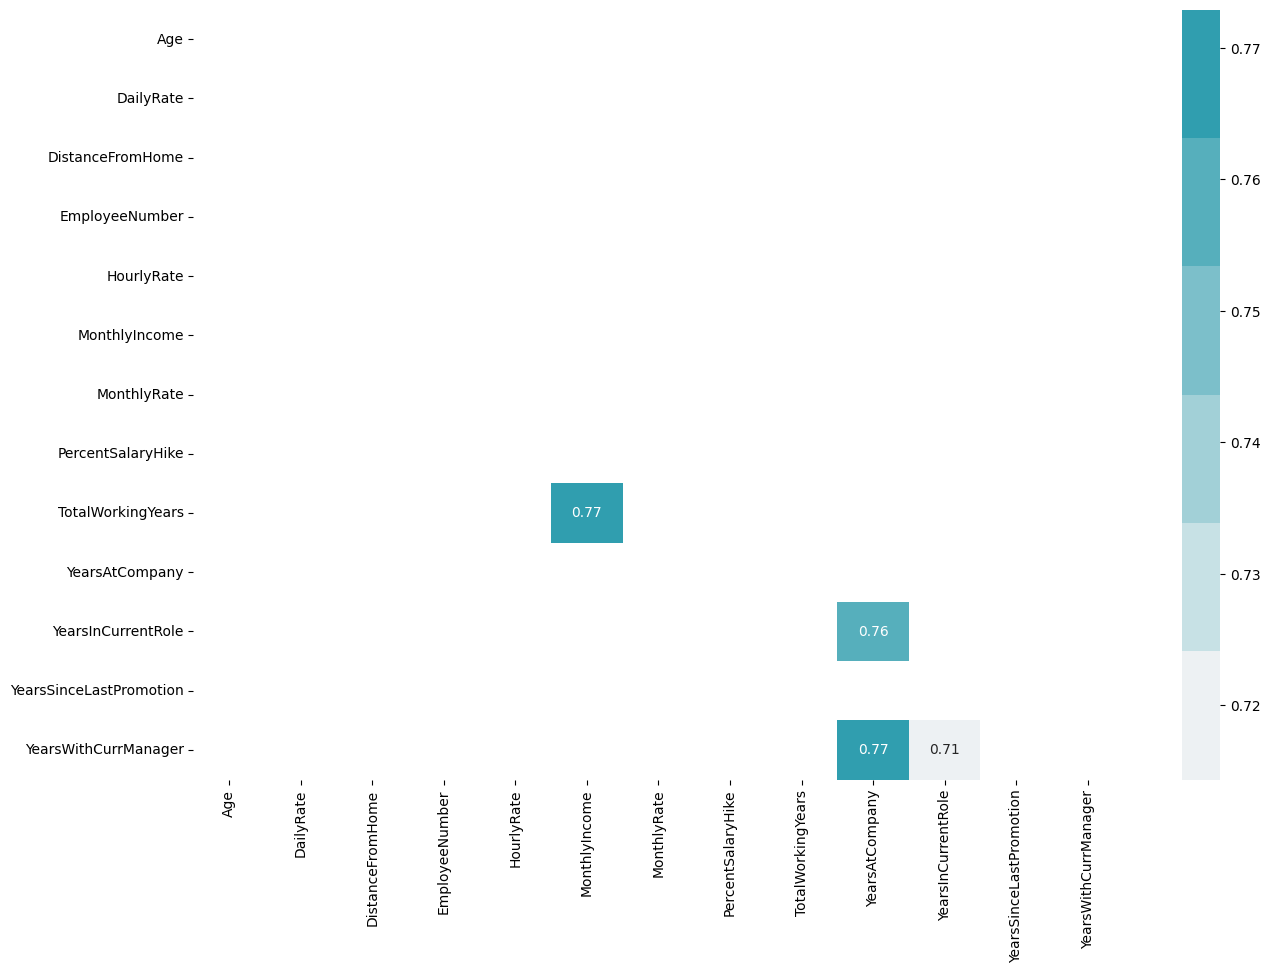

In [39]:
plot_numerical_correlation_heatmap(data_lite_df, continuous_columns_list, method='pearson', threshold=threshold, figsize=(15,10))

In [40]:
data_lite_df[continuous_columns_list].corr(method='spearman')

,Age,DailyRate,DistanceFromHome,EmployeeNumber,HourlyRate,MonthlyIncome,MonthlyRate,PercentSalaryHike,TotalWorkingYears,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
Age,1.000,0.007,-0.019,-0.002,0.029,0.472,0.017,0.008,0.657,0.252,0.198,0.174,0.195
DailyRate,0.007,1.000,-0.003,-0.052,0.024,0.016,-0.032,0.025,0.021,-0.010,0.007,-0.038,-0.005
DistanceFromHome,-0.019,-0.003,1.000,0.039,0.020,0.003,0.040,0.030,-0.003,0.011,0.014,-0.005,0.004
EmployeeNumber,-0.002,-0.052,0.039,1.000,0.035,0.002,0.012,-0.008,-0.004,0.013,-0.001,0.008,-0.005
HourlyRate,0.029,0.024,0.020,0.035,1.000,-0.020,-0.015,-0.010,-0.012,-0.029,-0.034,-0.052,-0.014
MonthlyIncome,0.472,0.016,0.003,0.002,-0.020,1.000,0.054,-0.034,0.710,0.464,0.395,0.265,0.365
MonthlyRate,0.017,-0.032,0.040,0.012,-0.015,0.054,1.000,-0.005,0.013,-0.030,-0.007,-0.016,-0.035
PercentSalaryHike,0.008,0.025,0.030,-0.008,-0.010,-0.034,-0.005,1.000,-0.026,-0.054,-0.026,-0.055,-0.026
TotalWorkingYears,0.657,0.021,-0.003,-0.004,-0.012,0.710,0.013,-0.026,1.000,0.594,0.493,0.335,0.495
YearsAtCompany,0.252,-0.010,0.011,0.013,-0.029,0.464,-0.030,-0.054,0.594,1.000,0.854,0.520,0.843


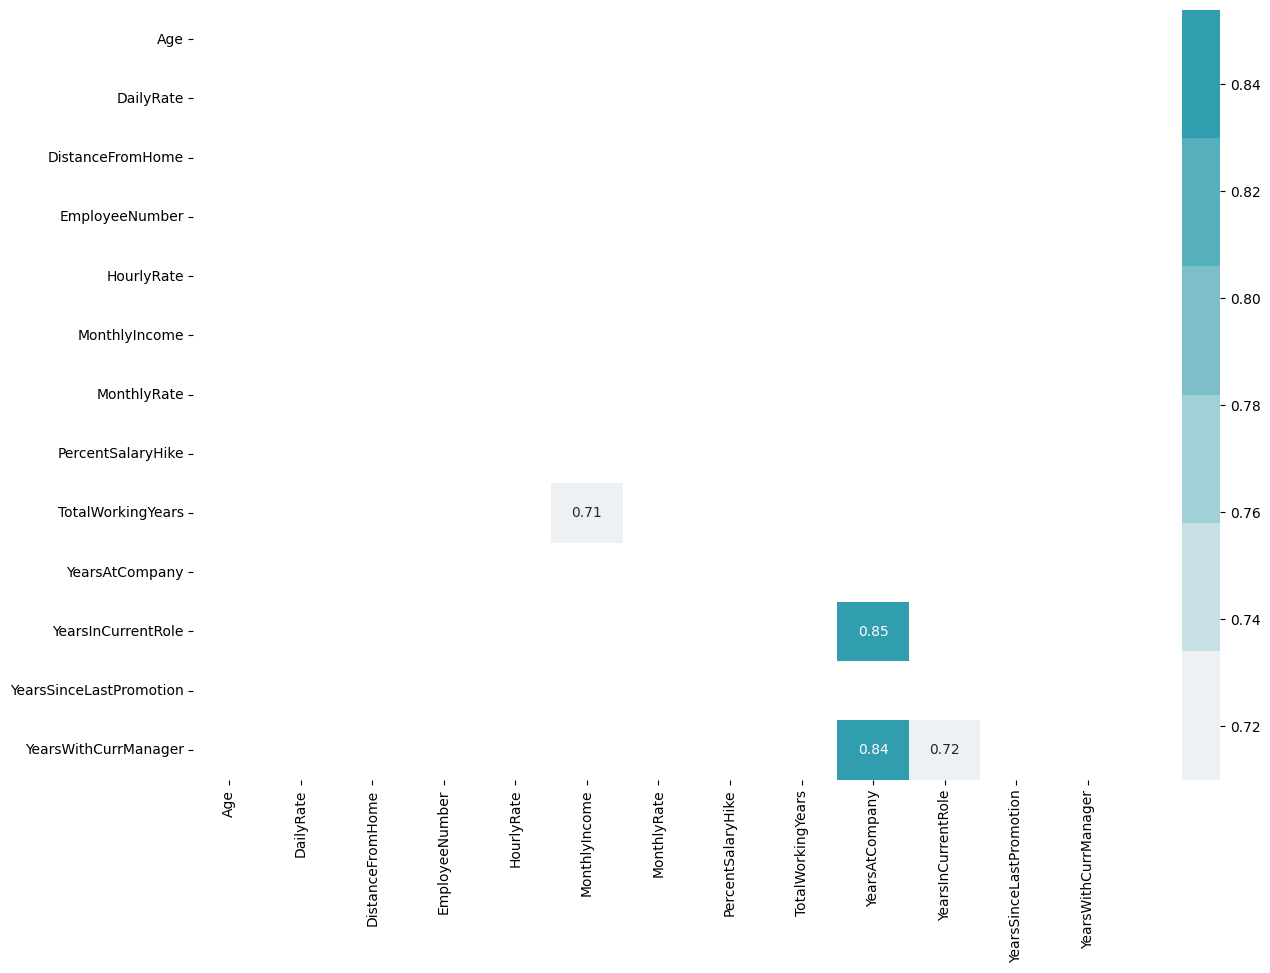

In [41]:
plot_numerical_correlation_heatmap(data_lite_df, continuous_columns_list, method='spearman', threshold=threshold, figsize=(15,10))

In [42]:
data_lite_df[continuous_columns_list].corr(method='kendall')

,Age,DailyRate,DistanceFromHome,EmployeeNumber,HourlyRate,MonthlyIncome,MonthlyRate,PercentSalaryHike,TotalWorkingYears,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
Age,1.000,0.005,-0.014,-0.001,0.020,0.334,0.012,0.006,0.502,0.187,0.146,0.130,0.144
DailyRate,0.005,1.000,-0.002,-0.034,0.016,0.011,-0.022,0.018,0.015,-0.007,0.005,-0.028,-0.003
DistanceFromHome,-0.014,-0.002,1.000,0.027,0.015,0.002,0.027,0.021,-0.002,0.008,0.010,-0.003,0.003
EmployeeNumber,-0.001,-0.034,0.027,1.000,0.024,0.001,0.008,-0.006,-0.003,0.009,-0.001,0.006,-0.004
HourlyRate,0.020,0.016,0.015,0.024,1.000,-0.013,-0.010,-0.007,-0.008,-0.020,-0.024,-0.039,-0.010
MonthlyIncome,0.334,0.011,0.002,0.001,-0.013,1.000,0.036,-0.024,0.536,0.342,0.293,0.196,0.270
MonthlyRate,0.012,-0.022,0.027,0.008,-0.010,0.036,1.000,-0.004,0.009,-0.021,-0.005,-0.012,-0.025
PercentSalaryHike,0.006,0.018,0.021,-0.006,-0.007,-0.024,-0.004,1.000,-0.018,-0.039,-0.019,-0.043,-0.019
TotalWorkingYears,0.502,0.015,-0.002,-0.003,-0.008,0.536,0.009,-0.018,1.000,0.500,0.396,0.255,0.396
YearsAtCompany,0.187,-0.007,0.008,0.009,-0.020,0.342,-0.021,-0.039,0.500,1.000,0.752,0.401,0.739


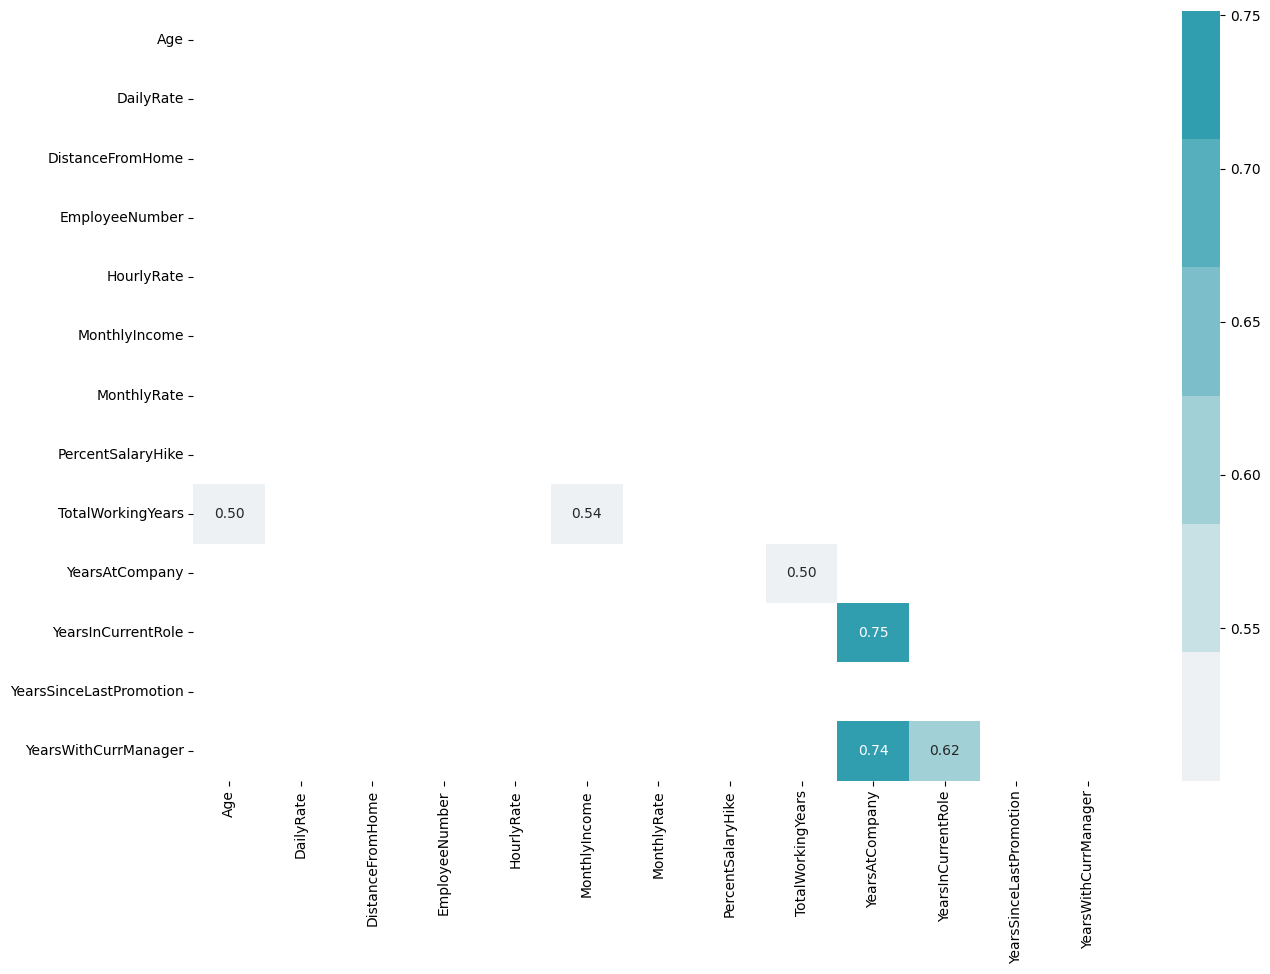

In [43]:
plot_numerical_correlation_heatmap(data_lite_df, continuous_columns_list, method='kendall', threshold=0.5, figsize=(15,10))

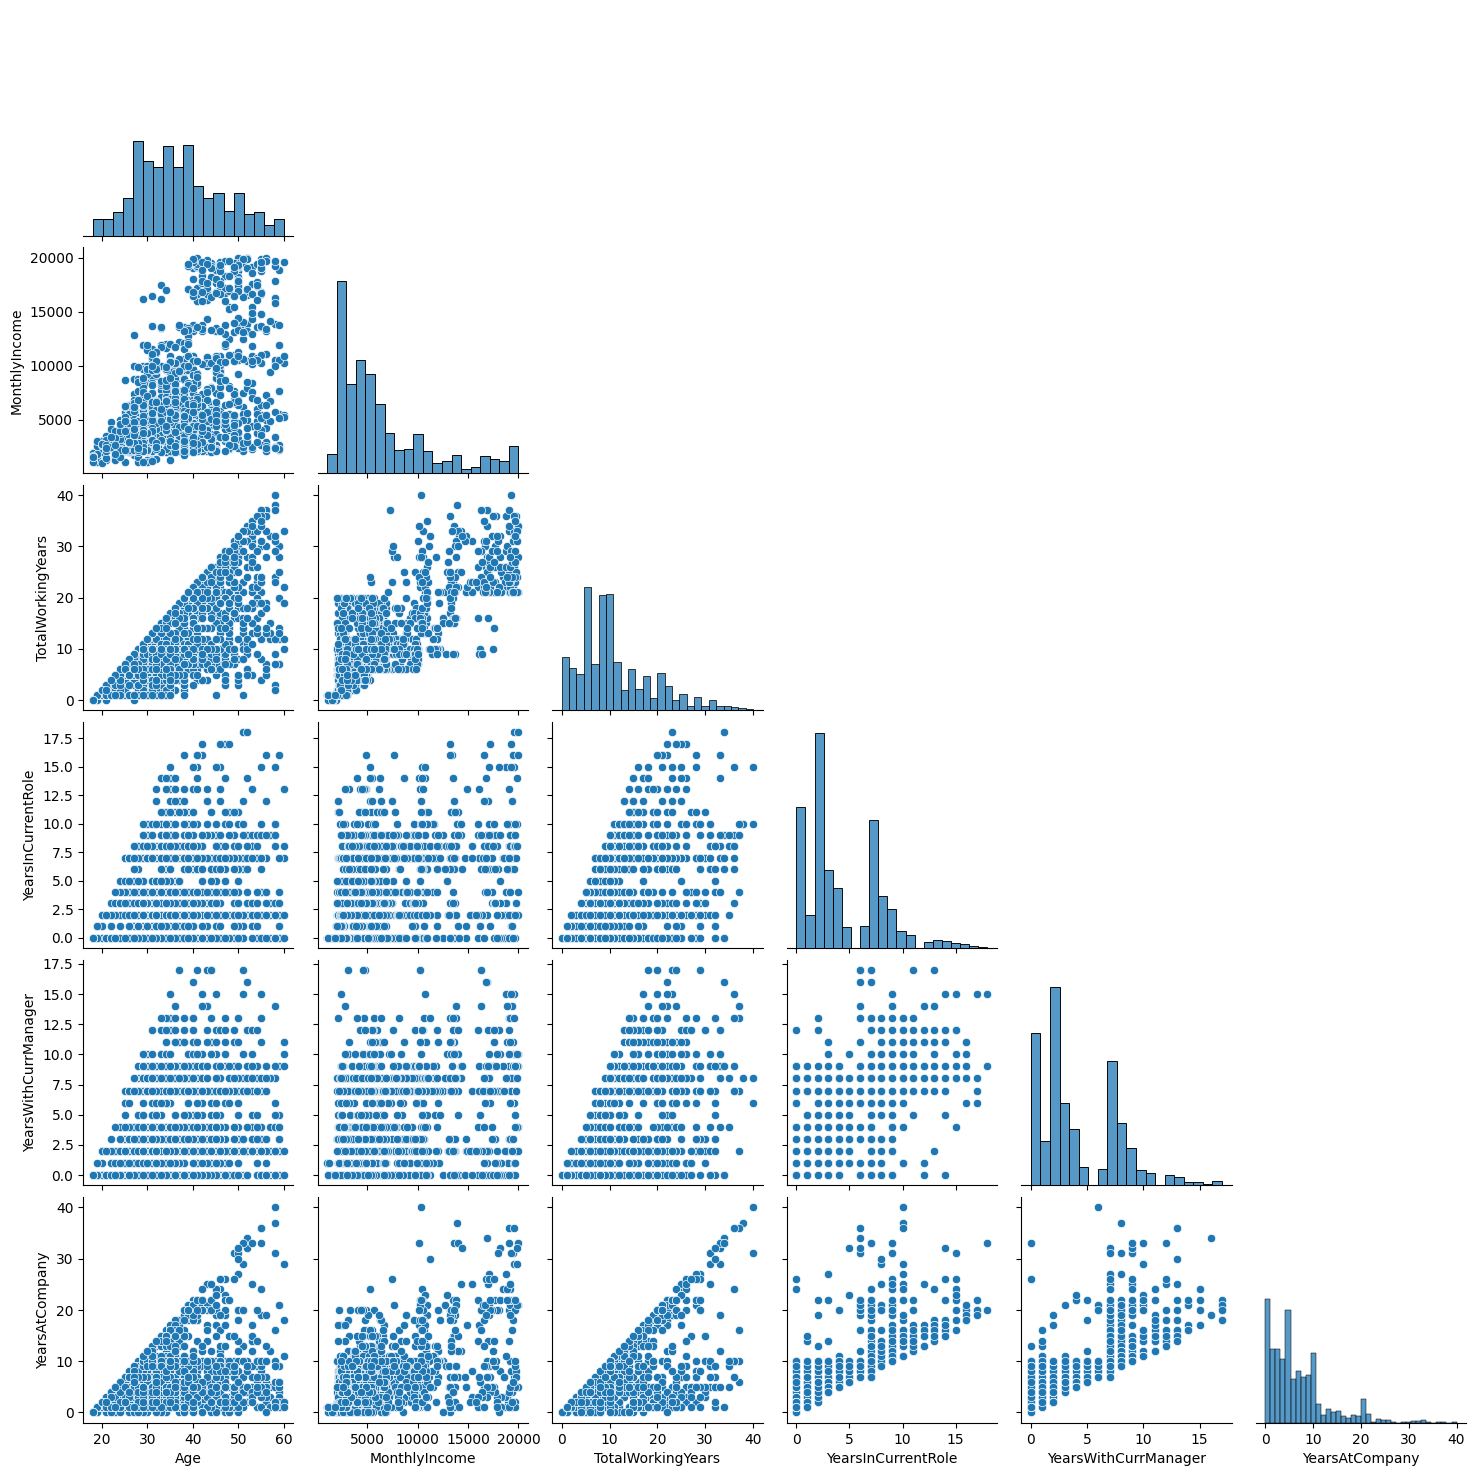

In [44]:
correlated_feats_list = ['Age', 'MonthlyIncome', 'TotalWorkingYears', 'YearsInCurrentRole', 'YearsWithCurrManager'
                        , 'YearsAtCompany']
sns.pairplot(data_lite_df[correlated_feats_list], corner=True);